In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
base = Path("..")
chemin_villes = base / "TP" / "villes_mapping.parquet"
chemin_poids = base / "TP" / "poids_regions_finie.nc"

# 2. OUVERTURE DES FICHIERS (C'est ici que ça change tout !)
# Pour le fichier Parquet (Villes) -> On utilise Pandas
print(f"📖 Lecture de : {chemin_villes.name} ...")
df_villes = pd.read_parquet(chemin_villes)

# Pour le fichier NetCDF (Poids) -> On utilise Xarray
if chemin_poids.exists():
    print(f"📖 Lecture de : {chemin_poids.name} ...")
    ds_poids = xr.open_dataset(chemin_poids)
else:
    print("⚠️ Fichier poids introuvable")

df_villes.head()

📖 Lecture de : villes_mapping.parquet ...
📖 Lecture de : poids_regions_finie.nc ...


,Ville,CodePostal,Lat_Ville,Lon_Ville,Grid_Lat,Grid_Lon
0,Frontignan,34110,43.448762,3.753064,43.50,3.75
1,Lunel,00000,43.674526,4.134806,43.75,4.25
2,Castelnau-le-Lez,34170,43.639317,3.913331,43.75,4.00
3,Lattes,34970,43.565399,3.901711,43.50,4.00
4,Sète,34200,43.401443,3.695977,43.50,3.75


# Nettoyage 


In [17]:
lat_col = next(c for c in df_villes.columns if 'lat' in c.lower())
lon_col = next(c for c in df_villes.columns if 'lon' in c.lower())

col_ville = "Ville" if "Ville" in df_villes.columns else df_villes.columns[0]
col_cp = "CodePostal" if "CodePostal" in df_villes.columns else None

df_villes = df_villes.dropna(subset=[lat_col, lon_col])

def make_label(row):
    if col_cp:
        return f"{row[col_ville]} ({row[col_cp]})"
    return row[col_ville]

df_villes["label"] = df_villes.apply(make_label, axis=1)

df_villes = df_villes.rename(columns={lat_col: "lat", lon_col: "lon"})

weights = ds_poids["weights"]

lat_name = next(c for c in weights.coords if "lat" in c.lower())
lon_name = next(c for c in weights.coords if "lon" in c.lower())

print("Coords détectées :", lat_name, lon_name)
print("Régions disponibles :", ds_poids.region.values)



Coords détectées : lat lon
Régions disponibles : ['Nouvelle-Aquitaine' 'Bretagne' 'Pays de la Loire' 'Grand Est'
 'Auvergne-Rhône-Alpes' "Provence-Alpes-Côte d'Azur" 'Occitanie'
 'Normandie' 'Centre-Val de Loire' 'Île-de-France' 'Hauts-de-France'
 'Bourgogne-Franche-Comté' 'Corse']


# Choix région

In [27]:
region_test = ds_poids.region.values[5]  # ou "Occitanie", "Bretagne", etc.
print("Région testée :", region_test)

mask = weights.sel(region=region_test)

print("Mask min/max :", float(mask.min()), float(mask.max()))


Région testée : Provence-Alpes-Côte d'Azur
Mask min/max : 0.0 0.7313537016191705


In [ ]:
print("Traitement de précision en cours...")

# 1. D'abord, on garde le rectangle (Bounding Box) car c'est un premier tri ultra rapide
# Cela élimine 90% des villes inutiles instantanément
valid_zone = mask.where(mask > 0, drop=True)
min_lat, max_lat = float(valid_zone.lat.min()), float(valid_zone.lat.max())
min_lon, max_lon = float(valid_zone.lon.min()), float(valid_zone.lon.max())

df_pre_filtered = df_villes[
    (df_villes["lat"] >= min_lat) &
    (df_villes["lat"] <= max_lat) &
    (df_villes["lon"] >= min_lon) &
    (df_villes["lon"] <= max_lon)
].copy()

# 2. MAINTENANT, LE FILTRAGE EXACT (SANS BOUCLE FOR)
# On crée des tableaux xarray avec les coordonnées des villes pré-filtrées
target_lats = xr.DataArray(df_pre_filtered["lat"].values, dims="points")
target_lons = xr.DataArray(df_pre_filtered["lon"].values, dims="points")

# On demande à Xarray : "Donne-moi la valeur du masque pour tous ces points"
# method="nearest" trouve le pixel de la région le plus proche de chaque ville
weights_values = mask.sel(lat=target_lats, lon=target_lons, method="nearest").values

# 3. On ne garde que les villes où le masque > 0 (donc DANS la région)
df_final = df_pre_filtered[weights_values > 0]

Traitement de précision en cours...


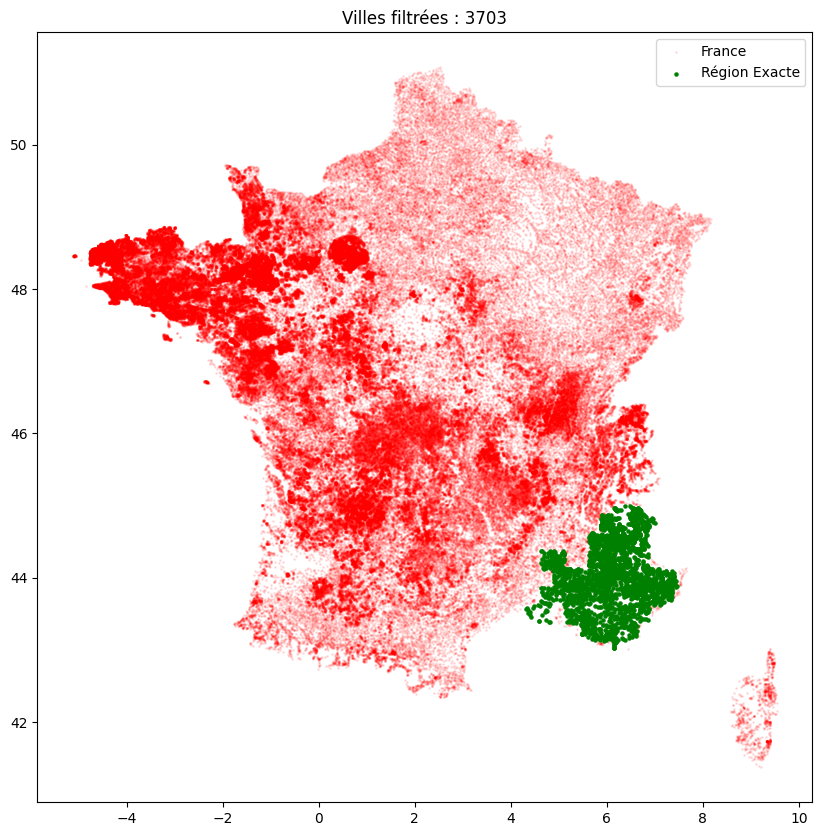

In [29]:
# Affichage graphique pour vérifier
plt.figure(figsize=(10, 10))
plt.scatter(df_villes.lon, df_villes.lat, c='red', s=1, alpha=0.1, label="France")
plt.scatter(df_final.lon, df_final.lat, c='green', s=5, label="Région Exacte")
plt.legend()
plt.title(f"Villes filtrées : {len(df_final)}")
plt.show()